<a href="https://colab.research.google.com/github/ndb796/StyleGAN-Embedding-PyTorch/blob/main/Face_Image_Encoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### <b>Download the pre-trained StyleGAN weights</b>

In [1]:
!git clone https://github.com/ndb796/PyTorch-StyleGAN-Face-Editting
%cd PyTorch-StyleGAN-Face-Editting
!unzip weights/karras2019stylegan-ffhq-1024x1024.zip -d weights/

Cloning into 'PyTorch-StyleGAN-Face-Editting'...
remote: Enumerating objects: 82, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 112 (delta 24), reused 43 (delta 1), pack-reused 30
Receiving objects: 100% (112/112), 95.16 MiB | 56.59 MiB/s, done.
Resolving deltas: 100% (30/30), done.
/content/PyTorch-StyleGAN-Face-Editting
Archive:  weights/karras2019stylegan-ffhq-1024x1024.zip
  inflating: weights/karras2019stylegan-ffhq-1024x1024.pt  


#### <b>Download celebrity face images</b>

In [2]:
!git clone https://github.com/ndb796/StyleGAN-Embedding-PyTorch
!cp -r StyleGAN-Embedding-PyTorch/aligned_images/ aligned_images/

Cloning into 'StyleGAN-Embedding-PyTorch'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 43 (delta 3), reused 32 (delta 3), pack-reused 0
Unpacking objects: 100% (43/43), done.


#### <b>Load required libraries</b>

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import models 
from torchvision import transforms
from torchvision.utils import save_image

from collections import OrderedDict
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

#### <b>Load StyleGAN model</b>

In [5]:
from stylegan_model import G_mapping
from stylegan_model import G_synthesis

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
resolution = 1024
weight_file = 'weights/karras2019stylegan-ffhq-1024x1024.pt'

g_all = nn.Sequential(OrderedDict([
    ('g_mapping', G_mapping()),
    ('g_synthesis', G_synthesis(resolution=resolution))    
]))
g_all.load_state_dict(torch.load(weight_file, map_location=device))
g_all.eval()
g_all.to(device)
 
g_mapping, g_synthesis = g_all[0], g_all[1]

#### <b>Define utilities</b>

In [6]:
# Read an image from a file
def image_reader(image_path, resize=None):
    with open(image_path, "rb") as f:
        image = Image.open(f)
        image = image.convert("RGB")
    if resize != None:
        image = image.resize((resize, resize))
    transform = transforms.Compose([
        transforms.ToTensor() # [0, 1]
    ])
    image = transform(image)
    image = image.unsqueeze(0) # (N, C, H, W)
    return image


# Show a torch image
def imshow(tensor):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    gray_scale = False
    if image.shape[0] == 1:
        gray_scale = True
    image = transforms.ToPILImage()(image)
    if gray_scale:
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(image)
    plt.show()


# Change the display resolution
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 80

#### <b>Embedding functions</b>

In [10]:
import warnings
warnings.filterwarnings(action='ignore')


# VGG feature extractor
class FeatureExtractor(torch.nn.Module):
    def __init__(self, n_layers):
        super(FeatureExtractor, self).__init__()
        extractor = models.vgg16(pretrained=True).features

        index = 0
        self.layers = nn.ModuleList([])
        for i in range(len(n_layers)):
            self.layers.append(torch.nn.Sequential())
            for j in range(index, n_layers[i] + 1):
                self.layers[i].add_module(str(j), extractor[j])
            index = n_layers[i] + 1

        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x):
        result = []
        for i in range(len(self.layers)):
            x = self.layers[i](x)
            result.append(x)

        return result

In [11]:
def loss_function(generated_image, target_image, feature_extractor):
    MSE = nn.MSELoss(reduction='mean')
    mse_loss = MSE(generated_image, target_image)

    upsample2d = torch.nn.Upsample(scale_factor=256 / resolution, mode='bilinear')
    real_features = feature_extractor(upsample2d(target_image))
    generated_features = feature_extractor(upsample2d(generated_image))

    perceptual_loss = 0
    for i in range(len(real_features)):
        perceptual_loss += MSE(real_features[i], generated_features[i])

    return mse_loss, perceptual_loss

#### <b>Embedding experiments</b>

[iter 1/1500] loss = 8.460090637207031, saved_path = barack_obama_1.png
[iter 100/1500] loss = 1.9235014915466309, saved_path = barack_obama_100.png
[iter 200/1500] loss = 1.772300362586975, saved_path = barack_obama_200.png
[iter 300/1500] loss = 1.472227692604065, saved_path = barack_obama_300.png
[iter 400/1500] loss = 1.3414555788040161, saved_path = barack_obama_400.png
[iter 500/1500] loss = 1.2734683752059937, saved_path = barack_obama_500.png
[iter 600/1500] loss = 1.1026816368103027, saved_path = barack_obama_600.png
[iter 700/1500] loss = 0.9302964210510254, saved_path = barack_obama_700.png
[iter 800/1500] loss = 0.8859303593635559, saved_path = barack_obama_800.png
[iter 900/1500] loss = 0.8694831132888794, saved_path = barack_obama_900.png
[iter 1000/1500] loss = 0.835263729095459, saved_path = barack_obama_1000.png
[iter 1100/1500] loss = 0.7994714975357056, saved_path = barack_obama_1100.png
[iter 1200/1500] loss = 0.7453335523605347, saved_path = barack_obama_1200.png
[

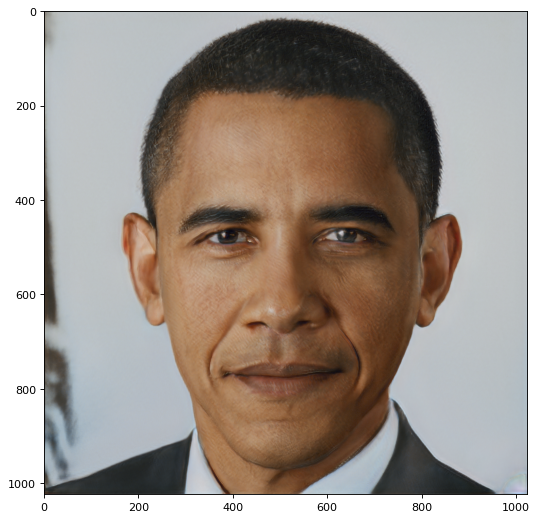

In [14]:
latent = torch.zeros((1, 18, 512), requires_grad=True, device=device) # latent vector
optimizer_latent = optim.Adam({latent}, lr=0.02, betas=(0.9, 0.999), eps=1e-8)

# VGG perceptual loss
feature_extractor = FeatureExtractor(n_layers=[1, 3, 13, 20]).to(device)

src = './aligned_images/barack_obama_01.png'
name = 'barack_obama'
image = image_reader(src, resize=resolution)
image = image.to(device)

# Start the optimization
iteration = 1500
for i in range(iteration):
    optimizer_latent.zero_grad()

    # generate an image from a latent vector
    generated_image = g_synthesis(latent)
    generated_image = (generated_image + 1.0) / 2.0
    generated_image = generated_image.clamp(0, 1)

    loss = 0
    mse_loss, perceptual_loss = loss_function(generated_image, image, feature_extractor)
    loss += mse_loss + perceptual_loss
    loss.backward() # calculate the gradient

    optimizer_latent.step() # update the latent vector

    if i == 0 or (i + 1) % 100 == 0:
        print(f'[iter {i + 1}/{iteration}] loss = {loss.detach().cpu().numpy()}, saved_path = {name}_{i + 1}.png')
        save_image(generated_image, f'{name}_{i + 1}.png')
        np.save(f'{name}_latent.npy', latent.detach().cpu().numpy())

print("[ Embedding Result ]")
imshow(generated_image)

[iter 1/1500] loss = 8.453764915466309, saved_path = hugh_jackman_1.png
[iter 100/1500] loss = 4.293663024902344, saved_path = hugh_jackman_100.png
[iter 200/1500] loss = 2.162092685699463, saved_path = hugh_jackman_200.png
[iter 300/1500] loss = 1.8194231986999512, saved_path = hugh_jackman_300.png
[iter 400/1500] loss = 1.6934161186218262, saved_path = hugh_jackman_400.png
[iter 500/1500] loss = 1.6918065547943115, saved_path = hugh_jackman_500.png
[iter 600/1500] loss = 1.4920786619186401, saved_path = hugh_jackman_600.png
[iter 700/1500] loss = 1.4399279356002808, saved_path = hugh_jackman_700.png
[iter 800/1500] loss = 1.4002485275268555, saved_path = hugh_jackman_800.png
[iter 900/1500] loss = 1.3450357913970947, saved_path = hugh_jackman_900.png
[iter 1000/1500] loss = 1.312853455543518, saved_path = hugh_jackman_1000.png
[iter 1100/1500] loss = 1.313759207725525, saved_path = hugh_jackman_1100.png
[iter 1200/1500] loss = 1.2317917346954346, saved_path = hugh_jackman_1200.png
[i

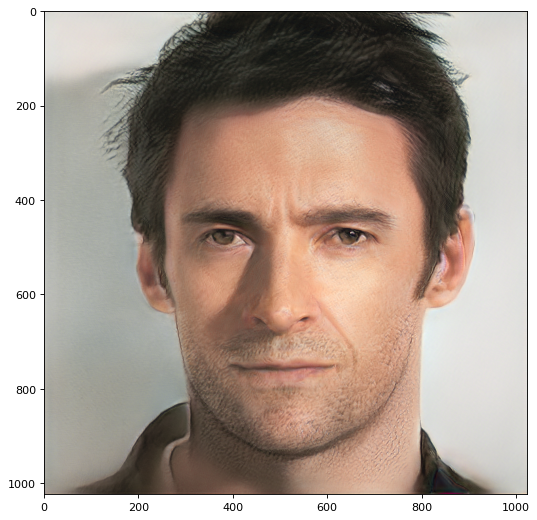

In [15]:
latent = torch.zeros((1, 18, 512), requires_grad=True, device=device) # latent vector
optimizer_latent = optim.Adam({latent}, lr=0.02, betas=(0.9, 0.999), eps=1e-8)

# VGG perceptual loss
feature_extractor = FeatureExtractor(n_layers=[1, 3, 13, 20]).to(device)

src = './aligned_images/hugh_jackman_01.png'
name = 'hugh_jackman'
image = image_reader(src, resize=resolution)
image = image.to(device)

# Start the optimization
iteration = 1500
for i in range(iteration):
    optimizer_latent.zero_grad()

    # generate an image from a latent vector
    generated_image = g_synthesis(latent)
    generated_image = (generated_image + 1.0) / 2.0
    generated_image = generated_image.clamp(0, 1)

    loss = 0
    mse_loss, perceptual_loss = loss_function(generated_image, image, feature_extractor)
    loss += mse_loss + perceptual_loss
    loss.backward() # calculate the gradient

    optimizer_latent.step() # update the latent vector

    if i == 0 or (i + 1) % 100 == 0:
        print(f'[iter {i + 1}/{iteration}] loss = {loss.detach().cpu().numpy()}, saved_path = {name}_{i + 1}.png')
        save_image(generated_image, f'{name}_{i + 1}.png')
        np.save(f'{name}_latent.npy', latent.detach().cpu().numpy())

print("[ Embedding Result ]")
imshow(generated_image)

[iter 1/1500] loss = 7.526566982269287, saved_path = anne_hathaway_1.png
[iter 100/1500] loss = 2.8866734504699707, saved_path = anne_hathaway_100.png
[iter 200/1500] loss = 2.6899611949920654, saved_path = anne_hathaway_200.png
[iter 300/1500] loss = 1.8440394401550293, saved_path = anne_hathaway_300.png
[iter 400/1500] loss = 1.6542720794677734, saved_path = anne_hathaway_400.png
[iter 500/1500] loss = 1.6034692525863647, saved_path = anne_hathaway_500.png
[iter 600/1500] loss = 1.4580724239349365, saved_path = anne_hathaway_600.png
[iter 700/1500] loss = 1.4354138374328613, saved_path = anne_hathaway_700.png
[iter 800/1500] loss = 1.299522876739502, saved_path = anne_hathaway_800.png
[iter 900/1500] loss = 1.2646002769470215, saved_path = anne_hathaway_900.png
[iter 1000/1500] loss = 1.1984699964523315, saved_path = anne_hathaway_1000.png
[iter 1100/1500] loss = 1.1942979097366333, saved_path = anne_hathaway_1100.png
[iter 1200/1500] loss = 1.2173055410385132, saved_path = anne_hath

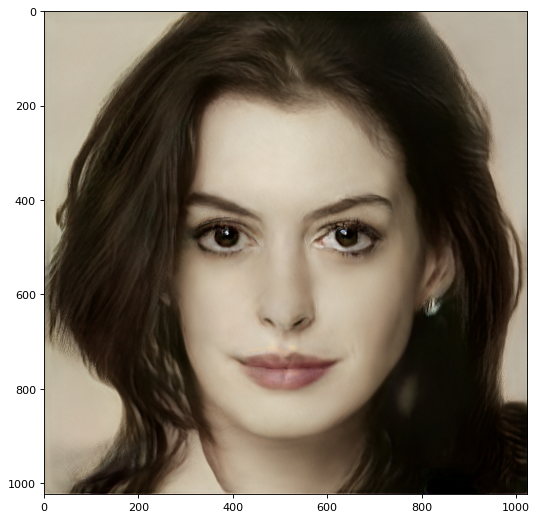

In [16]:
latent = torch.zeros((1, 18, 512), requires_grad=True, device=device) # latent vector
optimizer_latent = optim.Adam({latent}, lr=0.02, betas=(0.9, 0.999), eps=1e-8)

# VGG perceptual loss
feature_extractor = FeatureExtractor(n_layers=[1, 3, 13, 20]).to(device)

src = './aligned_images/anne_hathaway_01.png'
name = 'anne_hathaway'
image = image_reader(src, resize=resolution)
image = image.to(device)

# Start the optimization
iteration = 1500
for i in range(iteration):
    optimizer_latent.zero_grad()

    # generate an image from a latent vector
    generated_image = g_synthesis(latent)
    generated_image = (generated_image + 1.0) / 2.0
    generated_image = generated_image.clamp(0, 1)

    loss = 0
    mse_loss, perceptual_loss = loss_function(generated_image, image, feature_extractor)
    loss += mse_loss + perceptual_loss
    loss.backward() # calculate the gradient

    optimizer_latent.step() # update the latent vector

    if i == 0 or (i + 1) % 100 == 0:
        print(f'[iter {i + 1}/{iteration}] loss = {loss.detach().cpu().numpy()}, saved_path = {name}_{i + 1}.png')
        save_image(generated_image, f'{name}_{i + 1}.png')
        np.save(f'{name}_latent.npy', latent.detach().cpu().numpy())

print("[ Embedding Result ]")
imshow(generated_image)

[iter 1/1500] loss = 7.627197265625, saved_path = amanda_seyfried_1.png
[iter 100/1500] loss = 1.5265709161758423, saved_path = amanda_seyfried_100.png
[iter 200/1500] loss = 1.2239868640899658, saved_path = amanda_seyfried_200.png
[iter 300/1500] loss = 1.389626383781433, saved_path = amanda_seyfried_300.png
[iter 400/1500] loss = 1.024524450302124, saved_path = amanda_seyfried_400.png
[iter 500/1500] loss = 0.9299719333648682, saved_path = amanda_seyfried_500.png
[iter 600/1500] loss = 0.9013305902481079, saved_path = amanda_seyfried_600.png
[iter 700/1500] loss = 0.8323929309844971, saved_path = amanda_seyfried_700.png
[iter 800/1500] loss = 0.7937540411949158, saved_path = amanda_seyfried_800.png
[iter 900/1500] loss = 0.7966671586036682, saved_path = amanda_seyfried_900.png
[iter 1000/1500] loss = 0.7544798254966736, saved_path = amanda_seyfried_1000.png
[iter 1100/1500] loss = 0.722172737121582, saved_path = amanda_seyfried_1100.png
[iter 1200/1500] loss = 0.6914690732955933, sav

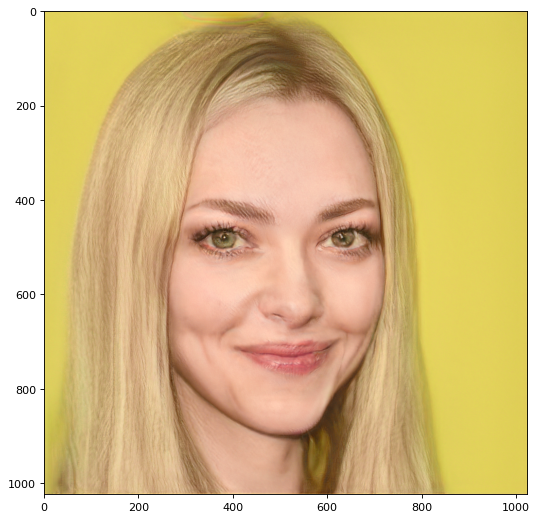

In [17]:
latent = torch.zeros((1, 18, 512), requires_grad=True, device=device) # latent vector
optimizer_latent = optim.Adam({latent}, lr=0.02, betas=(0.9, 0.999), eps=1e-8)

# VGG perceptual loss
feature_extractor = FeatureExtractor(n_layers=[1, 3, 13, 20]).to(device)

src = './aligned_images/amanda_seyfried_01.png'
name = 'amanda_seyfried'
image = image_reader(src, resize=resolution)
image = image.to(device)

# Start the optimization
iteration = 1500
for i in range(iteration):
    optimizer_latent.zero_grad()

    # generate an image from a latent vector
    generated_image = g_synthesis(latent)
    generated_image = (generated_image + 1.0) / 2.0
    generated_image = generated_image.clamp(0, 1)

    loss = 0
    mse_loss, perceptual_loss = loss_function(generated_image, image, feature_extractor)
    loss += mse_loss + perceptual_loss
    loss.backward() # calculate the gradient

    optimizer_latent.step() # update the latent vector

    if i == 0 or (i + 1) % 100 == 0:
        print(f'[iter {i + 1}/{iteration}] loss = {loss.detach().cpu().numpy()}, saved_path = {name}_{i + 1}.png')
        save_image(generated_image, f'{name}_{i + 1}.png')
        np.save(f'{name}_latent.npy', latent.detach().cpu().numpy())

print("[ Embedding Result ]")
imshow(generated_image)

[iter 1/1500] loss = 7.9404072761535645, saved_path = scarlett_johansson_1.png
[iter 100/1500] loss = 3.0944323539733887, saved_path = scarlett_johansson_100.png
[iter 200/1500] loss = 2.703300952911377, saved_path = scarlett_johansson_200.png
[iter 300/1500] loss = 2.4543981552124023, saved_path = scarlett_johansson_300.png
[iter 400/1500] loss = 2.334045886993408, saved_path = scarlett_johansson_400.png
[iter 500/1500] loss = 2.2398757934570312, saved_path = scarlett_johansson_500.png
[iter 600/1500] loss = 2.10162353515625, saved_path = scarlett_johansson_600.png
[iter 700/1500] loss = 2.0537126064300537, saved_path = scarlett_johansson_700.png
[iter 800/1500] loss = 2.0150022506713867, saved_path = scarlett_johansson_800.png
[iter 900/1500] loss = 1.9907927513122559, saved_path = scarlett_johansson_900.png
[iter 1000/1500] loss = 1.9928758144378662, saved_path = scarlett_johansson_1000.png
[iter 1100/1500] loss = 1.881392240524292, saved_path = scarlett_johansson_1100.png
[iter 120

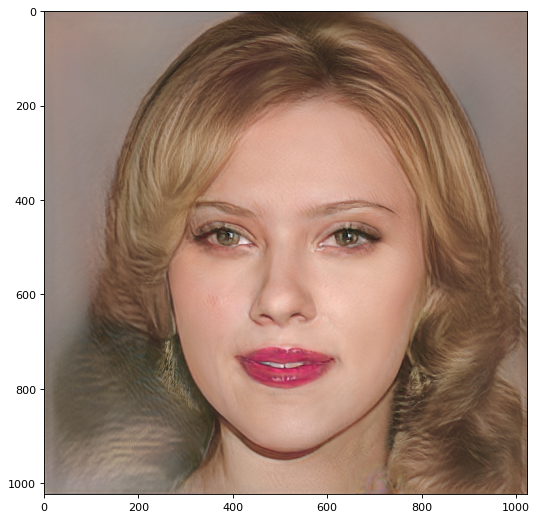

In [19]:
latent = torch.zeros((1, 18, 512), requires_grad=True, device=device) # latent vector
optimizer_latent = optim.Adam({latent}, lr=0.02, betas=(0.9, 0.999), eps=1e-8)

# VGG perceptual loss
feature_extractor = FeatureExtractor(n_layers=[1, 3, 13, 20]).to(device)

src = './aligned_images/scarlett_johansson_01.png'
name = 'scarlett_johansson'
image = image_reader(src, resize=resolution)
image = image.to(device)

# Start the optimization
iteration = 1500
for i in range(iteration):
    optimizer_latent.zero_grad()

    # generate an image from a latent vector
    generated_image = g_synthesis(latent)
    generated_image = (generated_image + 1.0) / 2.0
    generated_image = generated_image.clamp(0, 1)

    loss = 0
    mse_loss, perceptual_loss = loss_function(generated_image, image, feature_extractor)
    loss += mse_loss + perceptual_loss
    loss.backward() # calculate the gradient

    optimizer_latent.step() # update the latent vector

    if i == 0 or (i + 1) % 100 == 0:
        print(f'[iter {i + 1}/{iteration}] loss = {loss.detach().cpu().numpy()}, saved_path = {name}_{i + 1}.png')
        save_image(generated_image, f'{name}_{i + 1}.png')
        np.save(f'{name}_latent.npy', latent.detach().cpu().numpy())

print("[ Embedding Result ]")
imshow(generated_image)

[iter 1/1500] loss = 7.720891952514648, saved_path = natalie_portman_1.png
[iter 100/1500] loss = 3.0218348503112793, saved_path = natalie_portman_100.png
[iter 200/1500] loss = 2.5703601837158203, saved_path = natalie_portman_200.png
[iter 300/1500] loss = 2.413723945617676, saved_path = natalie_portman_300.png
[iter 400/1500] loss = 2.2713782787323, saved_path = natalie_portman_400.png
[iter 500/1500] loss = 2.1260993480682373, saved_path = natalie_portman_500.png
[iter 600/1500] loss = 2.0686166286468506, saved_path = natalie_portman_600.png
[iter 700/1500] loss = 1.9910376071929932, saved_path = natalie_portman_700.png
[iter 800/1500] loss = 1.9328492879867554, saved_path = natalie_portman_800.png
[iter 900/1500] loss = 1.9450139999389648, saved_path = natalie_portman_900.png
[iter 1000/1500] loss = 1.854278802871704, saved_path = natalie_portman_1000.png
[iter 1100/1500] loss = 1.8479241132736206, saved_path = natalie_portman_1100.png
[iter 1200/1500] loss = 1.7963165044784546, sa

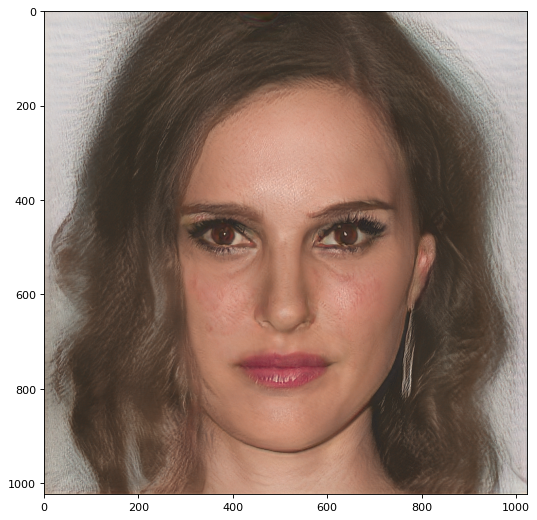

In [20]:
latent = torch.zeros((1, 18, 512), requires_grad=True, device=device) # latent vector
optimizer_latent = optim.Adam({latent}, lr=0.02, betas=(0.9, 0.999), eps=1e-8)

# VGG perceptual loss
feature_extractor = FeatureExtractor(n_layers=[1, 3, 13, 20]).to(device)

src = './aligned_images/natalie_portman_01.png'
name = 'natalie_portman'
image = image_reader(src, resize=resolution)
image = image.to(device)

# Start the optimization
iteration = 1500
for i in range(iteration):
    optimizer_latent.zero_grad()

    # generate an image from a latent vector
    generated_image = g_synthesis(latent)
    generated_image = (generated_image + 1.0) / 2.0
    generated_image = generated_image.clamp(0, 1)

    loss = 0
    mse_loss, perceptual_loss = loss_function(generated_image, image, feature_extractor)
    loss += mse_loss + perceptual_loss
    loss.backward() # calculate the gradient

    optimizer_latent.step() # update the latent vector

    if i == 0 or (i + 1) % 100 == 0:
        print(f'[iter {i + 1}/{iteration}] loss = {loss.detach().cpu().numpy()}, saved_path = {name}_{i + 1}.png')
        save_image(generated_image, f'{name}_{i + 1}.png')
        np.save(f'{name}_latent.npy', latent.detach().cpu().numpy())

print("[ Embedding Result ]")
imshow(generated_image)

[iter 1/1500] loss = 7.6730828285217285, saved_path = keanu_reeves_1.png
[iter 100/1500] loss = 2.3072516918182373, saved_path = keanu_reeves_100.png
[iter 200/1500] loss = 1.6644678115844727, saved_path = keanu_reeves_200.png
[iter 300/1500] loss = 1.3010555505752563, saved_path = keanu_reeves_300.png
[iter 400/1500] loss = 1.5071961879730225, saved_path = keanu_reeves_400.png
[iter 500/1500] loss = 1.2192133665084839, saved_path = keanu_reeves_500.png
[iter 600/1500] loss = 1.0030925273895264, saved_path = keanu_reeves_600.png
[iter 700/1500] loss = 0.9553510546684265, saved_path = keanu_reeves_700.png
[iter 800/1500] loss = 0.9618668556213379, saved_path = keanu_reeves_800.png
[iter 900/1500] loss = 0.8696948289871216, saved_path = keanu_reeves_900.png
[iter 1000/1500] loss = 0.8298503160476685, saved_path = keanu_reeves_1000.png
[iter 1100/1500] loss = 0.8221685290336609, saved_path = keanu_reeves_1100.png
[iter 1200/1500] loss = 0.7889202833175659, saved_path = keanu_reeves_1200.p

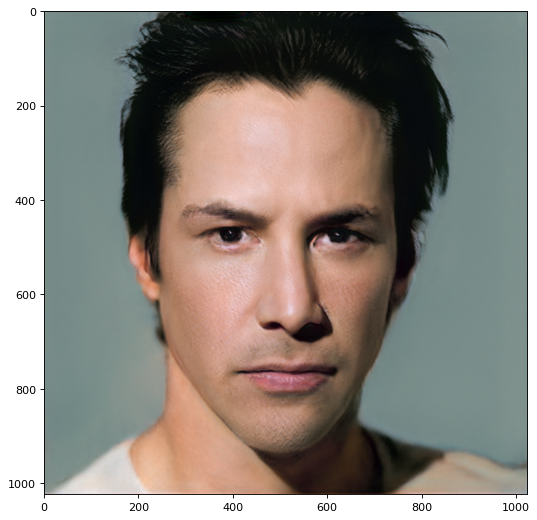

In [21]:
latent = torch.zeros((1, 18, 512), requires_grad=True, device=device) # latent vector
optimizer_latent = optim.Adam({latent}, lr=0.02, betas=(0.9, 0.999), eps=1e-8)

# VGG perceptual loss
feature_extractor = FeatureExtractor(n_layers=[1, 3, 13, 20]).to(device)

src = './aligned_images/keanu_reeves_01.png'
name = 'keanu_reeves'
image = image_reader(src, resize=resolution)
image = image.to(device)

# Start the optimization
iteration = 1500
for i in range(iteration):
    optimizer_latent.zero_grad()

    # generate an image from a latent vector
    generated_image = g_synthesis(latent)
    generated_image = (generated_image + 1.0) / 2.0
    generated_image = generated_image.clamp(0, 1)

    loss = 0
    mse_loss, perceptual_loss = loss_function(generated_image, image, feature_extractor)
    loss += mse_loss + perceptual_loss
    loss.backward() # calculate the gradient

    optimizer_latent.step() # update the latent vector

    if i == 0 or (i + 1) % 100 == 0:
        print(f'[iter {i + 1}/{iteration}] loss = {loss.detach().cpu().numpy()}, saved_path = {name}_{i + 1}.png')
        save_image(generated_image, f'{name}_{i + 1}.png')
        np.save(f'{name}_latent.npy', latent.detach().cpu().numpy())

print("[ Embedding Result ]")
imshow(generated_image)

[iter 1/1500] loss = 7.572032928466797, saved_path = donald_trump_1.png
[iter 100/1500] loss = 2.7073144912719727, saved_path = donald_trump_100.png
[iter 200/1500] loss = 1.924714207649231, saved_path = donald_trump_200.png
[iter 300/1500] loss = 1.6407361030578613, saved_path = donald_trump_300.png
[iter 400/1500] loss = 1.4477946758270264, saved_path = donald_trump_400.png
[iter 500/1500] loss = 1.391309142112732, saved_path = donald_trump_500.png
[iter 600/1500] loss = 1.3195924758911133, saved_path = donald_trump_600.png
[iter 700/1500] loss = 1.2202304601669312, saved_path = donald_trump_700.png
[iter 800/1500] loss = 1.1902955770492554, saved_path = donald_trump_800.png
[iter 900/1500] loss = 1.1142209768295288, saved_path = donald_trump_900.png
[iter 1000/1500] loss = 1.0997482538223267, saved_path = donald_trump_1000.png
[iter 1100/1500] loss = 1.0712600946426392, saved_path = donald_trump_1100.png
[iter 1200/1500] loss = 1.0216580629348755, saved_path = donald_trump_1200.png


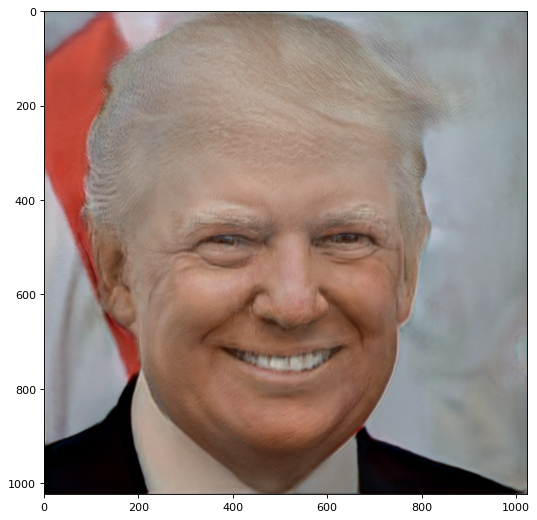

In [22]:
latent = torch.zeros((1, 18, 512), requires_grad=True, device=device) # latent vector
optimizer_latent = optim.Adam({latent}, lr=0.02, betas=(0.9, 0.999), eps=1e-8)

# VGG perceptual loss
feature_extractor = FeatureExtractor(n_layers=[1, 3, 13, 20]).to(device)

src = './aligned_images/donald_trump_01.png'
name = 'donald_trump'
image = image_reader(src, resize=resolution)
image = image.to(device)

# Start the optimization
iteration = 1500
for i in range(iteration):
    optimizer_latent.zero_grad()

    # generate an image from a latent vector
    generated_image = g_synthesis(latent)
    generated_image = (generated_image + 1.0) / 2.0
    generated_image = generated_image.clamp(0, 1)

    loss = 0
    mse_loss, perceptual_loss = loss_function(generated_image, image, feature_extractor)
    loss += mse_loss + perceptual_loss
    loss.backward() # calculate the gradient

    optimizer_latent.step() # update the latent vector

    if i == 0 or (i + 1) % 100 == 0:
        print(f'[iter {i + 1}/{iteration}] loss = {loss.detach().cpu().numpy()}, saved_path = {name}_{i + 1}.png')
        save_image(generated_image, f'{name}_{i + 1}.png')
        np.save(f'{name}_latent.npy', latent.detach().cpu().numpy())

print("[ Embedding Result ]")
imshow(generated_image)

[iter 1/1500] loss = 7.513219833374023, saved_path = tom_hardy_1.png
[iter 100/1500] loss = 1.840442180633545, saved_path = tom_hardy_100.png
[iter 200/1500] loss = 1.3810653686523438, saved_path = tom_hardy_200.png
[iter 300/1500] loss = 1.2010594606399536, saved_path = tom_hardy_300.png
[iter 400/1500] loss = 1.1332530975341797, saved_path = tom_hardy_400.png
[iter 500/1500] loss = 1.0885969400405884, saved_path = tom_hardy_500.png
[iter 600/1500] loss = 1.0403614044189453, saved_path = tom_hardy_600.png
[iter 700/1500] loss = 1.001879334449768, saved_path = tom_hardy_700.png
[iter 800/1500] loss = 0.9398815035820007, saved_path = tom_hardy_800.png
[iter 900/1500] loss = 0.9294030666351318, saved_path = tom_hardy_900.png
[iter 1000/1500] loss = 0.8824503421783447, saved_path = tom_hardy_1000.png
[iter 1100/1500] loss = 0.8967541456222534, saved_path = tom_hardy_1100.png
[iter 1200/1500] loss = 0.8946991562843323, saved_path = tom_hardy_1200.png
[iter 1300/1500] loss = 0.8661884069442

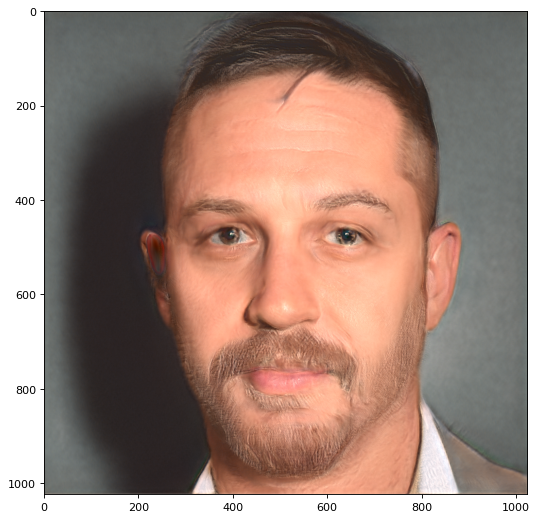

In [23]:
latent = torch.zeros((1, 18, 512), requires_grad=True, device=device) # latent vector
optimizer_latent = optim.Adam({latent}, lr=0.02, betas=(0.9, 0.999), eps=1e-8)

# VGG perceptual loss
feature_extractor = FeatureExtractor(n_layers=[1, 3, 13, 20]).to(device)

src = './aligned_images/tom_hardy_01.png'
name = 'tom_hardy'
image = image_reader(src, resize=resolution)
image = image.to(device)

# Start the optimization
iteration = 1500
for i in range(iteration):
    optimizer_latent.zero_grad()

    # generate an image from a latent vector
    generated_image = g_synthesis(latent)
    generated_image = (generated_image + 1.0) / 2.0
    generated_image = generated_image.clamp(0, 1)

    loss = 0
    mse_loss, perceptual_loss = loss_function(generated_image, image, feature_extractor)
    loss += mse_loss + perceptual_loss
    loss.backward() # calculate the gradient

    optimizer_latent.step() # update the latent vector

    if i == 0 or (i + 1) % 100 == 0:
        print(f'[iter {i + 1}/{iteration}] loss = {loss.detach().cpu().numpy()}, saved_path = {name}_{i + 1}.png')
        save_image(generated_image, f'{name}_{i + 1}.png')
        np.save(f'{name}_latent.npy', latent.detach().cpu().numpy())

print("[ Embedding Result ]")
imshow(generated_image)

[iter 1/1500] loss = 7.868997097015381, saved_path = emma_stone_1.png
[iter 100/1500] loss = 2.5625674724578857, saved_path = emma_stone_100.png
[iter 200/1500] loss = 1.962233304977417, saved_path = emma_stone_200.png
[iter 300/1500] loss = 1.6881673336029053, saved_path = emma_stone_300.png
[iter 400/1500] loss = 1.5628337860107422, saved_path = emma_stone_400.png
[iter 500/1500] loss = 1.4280098676681519, saved_path = emma_stone_500.png
[iter 600/1500] loss = 1.425421118736267, saved_path = emma_stone_600.png
[iter 700/1500] loss = 1.2686595916748047, saved_path = emma_stone_700.png
[iter 800/1500] loss = 1.2276859283447266, saved_path = emma_stone_800.png
[iter 900/1500] loss = 1.2553414106369019, saved_path = emma_stone_900.png
[iter 1000/1500] loss = 1.222631812095642, saved_path = emma_stone_1000.png
[iter 1100/1500] loss = 1.1564387083053589, saved_path = emma_stone_1100.png
[iter 1200/1500] loss = 1.1695500612258911, saved_path = emma_stone_1200.png
[iter 1300/1500] loss = 1.1

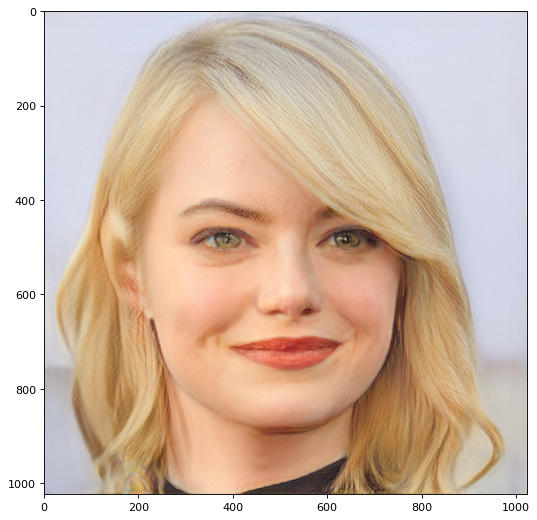

In [24]:
latent = torch.zeros((1, 18, 512), requires_grad=True, device=device) # latent vector
optimizer_latent = optim.Adam({latent}, lr=0.02, betas=(0.9, 0.999), eps=1e-8)

# VGG perceptual loss
feature_extractor = FeatureExtractor(n_layers=[1, 3, 13, 20]).to(device)

src = './aligned_images/emma_stone_01.png'
name = 'emma_stone'
image = image_reader(src, resize=resolution)
image = image.to(device)

# Start the optimization
iteration = 1500
for i in range(iteration):
    optimizer_latent.zero_grad()

    # generate an image from a latent vector
    generated_image = g_synthesis(latent)
    generated_image = (generated_image + 1.0) / 2.0
    generated_image = generated_image.clamp(0, 1)

    loss = 0
    mse_loss, perceptual_loss = loss_function(generated_image, image, feature_extractor)
    loss += mse_loss + perceptual_loss
    loss.backward() # calculate the gradient

    optimizer_latent.step() # update the latent vector

    if i == 0 or (i + 1) % 100 == 0:
        print(f'[iter {i + 1}/{iteration}] loss = {loss.detach().cpu().numpy()}, saved_path = {name}_{i + 1}.png')
        save_image(generated_image, f'{name}_{i + 1}.png')
        np.save(f'{name}_latent.npy', latent.detach().cpu().numpy())

print("[ Embedding Result ]")
imshow(generated_image)